# Analyze Region 2 - Western Canada and USA

This notebook analyzes the largest glaciers in Region 2 - Western Canada and USA

Notes:
* GLIMS has its 3rd largest glacier as Jewakwa (131.1 km2) but RGI has its third largest glacier as RGI60-02.03578 (136.85) which is not Jewakwa but right next to it. What is that glacier in RGI? After searching google and google scholar, I found no information about this the glacier that is in RGI.
* Primeclass isn't set in the GLIMS database for any of these glaciers. Need to determine one. Perhaps 6 - mountain glacier?
* Jewakwa is on Homathko Icefield (https://pbase.com/nolock/homathko)
* Klinaklini Glacier is on  Ha-litzuk Icefield

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Show Region

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "2"
region_name = "Western Canada and USA"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 6

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1
region_index_1 = 1
region_index_2 = 2

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

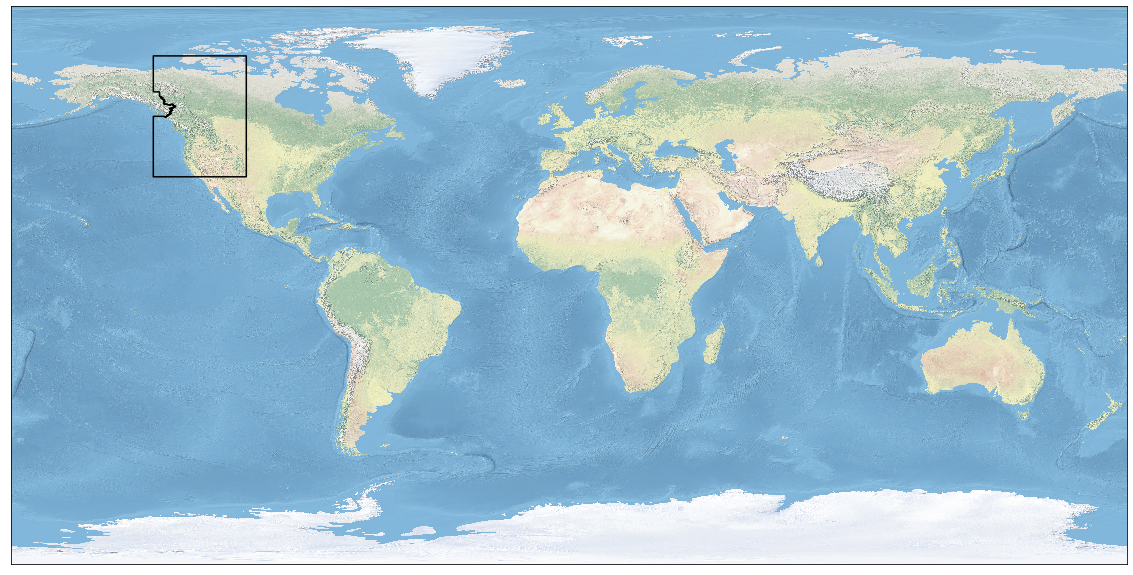

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region 7 outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

# Glaciers

In [6]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [7]:
glims_glaciers_df

region_no         glac_id   area  db_area  width  length  primeclass  \
0          2  G234082E51540N  469.8  469.766    0.0     0.0         0.0   
1          2  G234658E51318N  153.4  153.427    0.0     0.0         0.0   
2          2  G235401E51143N  131.1  131.112    0.0     0.0         0.0   

   min_elev  mean_elev  max_elev             src_date           glac_name  \
0       0.0        0.0       0.0  2004-07-22T00:00:00  Klinaklini Glacier   
1       0.0        0.0       0.0  2004-07-22T00:00:00    Franklin Glacier   
2       0.0        0.0       0.0  2004-08-09T00:00:00     Jewakwa Glacier   

                                            geometry  
0  POLYGON Z ((-125.771121 51.61014 0, -125.77210...  
1  POLYGON Z ((-125.228529 51.310758 0, -125.2275...  
2  POLYGON Z ((-124.539706 51.17575 0, -124.53989...

In [8]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [9]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
0  RGI60-02.05157  G234050E51502N  20049999  20069999 -125.950  51.5024   
1  RGI60-02.12428  G234663E51321N  20049999  20069999 -125.337  51.3210   
2  RGI60-02.03578  G235390E51067N  20049999  20069999 -124.610  51.0666   

  O1Region O2Region     Area  Zmin  ...  Aspect   Lmax  Status  Connect  Form  \
0        2        2  469.766   146  ...     122  43272       0        0     0   
1        2        2  153.427   587  ...     234  26870       0        0     0   
2        2        2  136.850   589  ...     283  23803       0        0     0   

   TermType  Surging  Linkages  Name  \
0         0        0         9  None   
1         0        0         9  None   
2         0        0         9  None   

                                            geometry  
0  POLYGON ((-125.853488 51.64645400000006, -125....  
1  POLYGON ((-125.34191 51.40133500000007, -125.3...  
2  POLYGON ((-124.648724 51.11781500000006, -124....  

[3 rows x 23 columns]

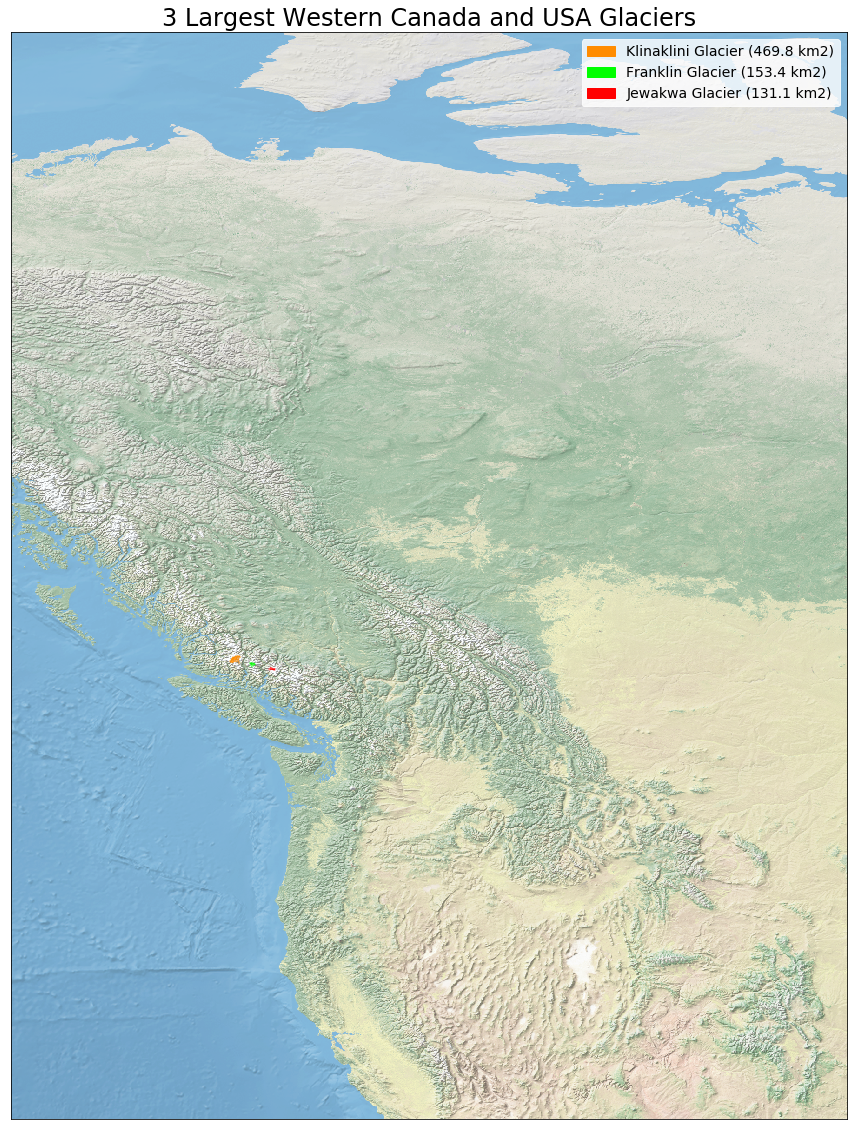

In [10]:
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['darkorange', 'lime', 'red']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='darkorange')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='red')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create final data files

In [11]:
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_data_df = glims_glaciers_df.drop(['db_area', 'width', 'length', 'primeclass', 
                                                          'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_data_df['primeclass'] = primeclass

# Reorder the columns of the dataframe
final_data_df = final_data_df[['region_no', 'reg_name', 'glac_name', 'glac_id', 
                               'primeclass', 'area', 'src_date', 'geometry']]

# Rename some columns
final_data_df.rename(columns={'glac_id': 'glims_id', 'area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

In [12]:
final_data_df

region_no                reg_name           glac_name        glims_id  \
0          2  Western Canada and USA  Klinaklini Glacier  G234082E51540N   
1          2  Western Canada and USA    Franklin Glacier  G234658E51318N   
2          2  Western Canada and USA     Jewakwa Glacier  G235401E51143N   

   primeclass  area_km2                 date  \
0           4     469.8  2004-07-22T00:00:00   
1           4     153.4  2004-07-22T00:00:00   
2           4     131.1  2004-08-09T00:00:00   

                                            geometry  
0  POLYGON Z ((-125.771121 51.61014 0, -125.77210...  
1  POLYGON Z ((-125.228529 51.310758 0, -125.2275...  
2  POLYGON Z ((-124.539706 51.17575 0, -124.53989...

In [13]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are equal, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    #print('glims date: ' + glims_date)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    #print('rgi date:   ' + rgi_date)
    
    if glims_date == rgi_date:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['area'][x], rgi_glaciers_df['Area'][x]])
        print('Averaging area: ' + str(area))
    elif glims_date > rgi_date:
        # Use GLIMS area for the area
        area = glims_glaciers_df['area'][x]
        print('Using GLIMS area ' + str(area))
    elif rgi_date > glims_date:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x]
        print('Using RGI area ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    # Set the area in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_km2')] = area
    
    # Clean the date format in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]

Using RGI area469.766
Using RGI area153.427
Using RGI area136.85


In [14]:
final_data_df

region_no                reg_name           glac_name        glims_id  \
0          2  Western Canada and USA  Klinaklini Glacier  G234082E51540N   
1          2  Western Canada and USA    Franklin Glacier  G234658E51318N   
2          2  Western Canada and USA     Jewakwa Glacier  G235401E51143N   

   primeclass  area_km2        date  \
0           4   469.766  2004-07-22   
1           4   153.427  2004-07-22   
2           4   136.850  2004-08-09   

                                            geometry  
0  POLYGON Z ((-125.771121 51.61014 0, -125.77210...  
1  POLYGON Z ((-125.228529 51.310758 0, -125.2275...  
2  POLYGON Z ((-124.539706 51.17575 0, -124.53989...

In [15]:
xx = final_data_df['date'][0]
type(xx)

str

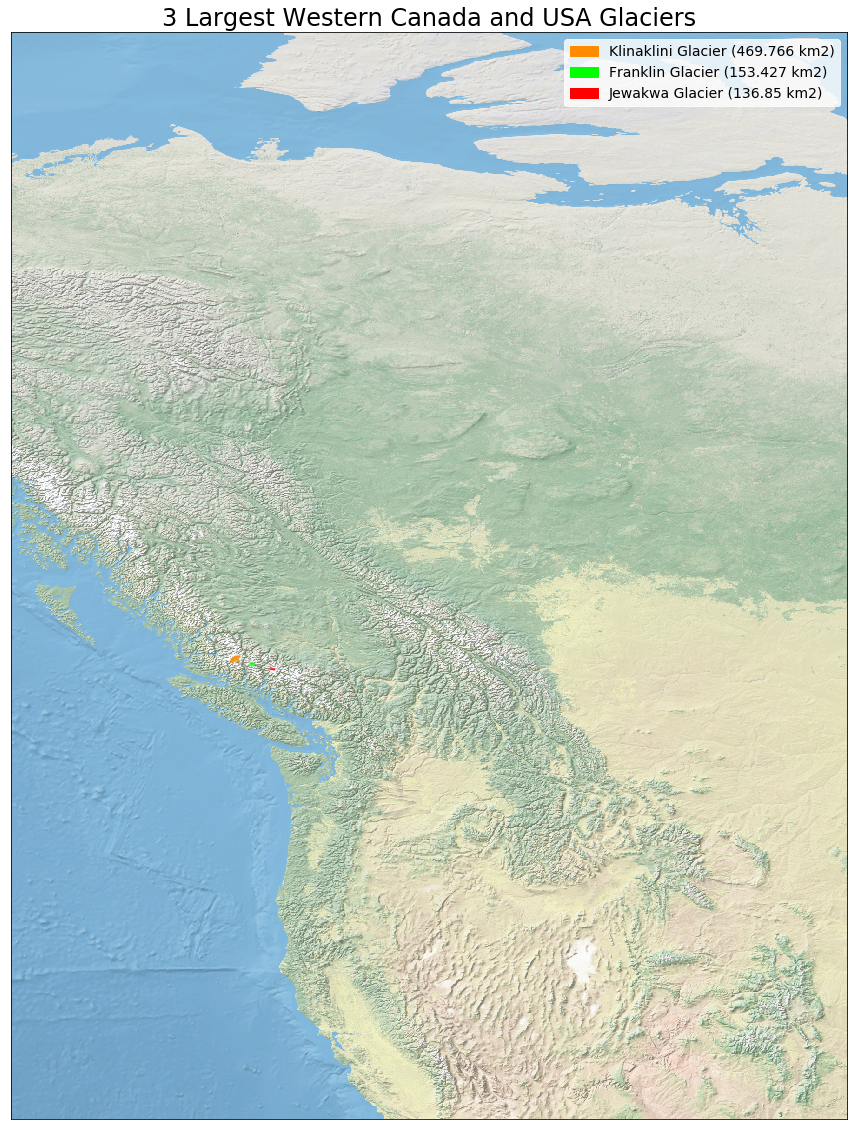

In [16]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['darkorange', 'lime', 'red']
legend_labels = [final_data_df['glac_name'][0] + ' (' + str(final_data_df['area_km2'][0]) + ' km2)',
                 final_data_df['glac_name'][1] + ' (' + str(final_data_df['area_km2'][1]) + ' km2)',
                 final_data_df['glac_name'][2] + ' (' + str(final_data_df['area_km2'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_data_df.iloc[0:1].plot(ax=ax, color='darkorange')
final_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_data_df.iloc[2:3].plot(ax=ax, color='red')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

In [17]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(zipfile_fn) == False:
    # Create the shapefile
    final_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_data_df.to_file(driver='ESRI Shapefile', filename=final_data_fn)
    print("Saving data file: " + final_data_fn)
    
    # Zip up the shapefile
    zipfile_fn = ws.zipshp(final_data_fn, Delete=True)
    print("Creating zipfile: " + zipfile_fn)
else:
    print(zipfile_fn + " already extists")

Saving data file: data/final-dataset/region-2-largest-glaciers.shp
Creating zipfile: data/final-dataset\region-2-largest-glaciers.zip


In [18]:
final_data_df

region_no                reg_name           glac_name        glims_id  \
0          2  Western Canada and USA  Klinaklini Glacier  G234082E51540N   
1          2  Western Canada and USA    Franklin Glacier  G234658E51318N   
2          2  Western Canada and USA     Jewakwa Glacier  G235401E51143N   

   primeclass  area_km2        date  \
0           4   469.766  2004-07-22   
1           4   153.427  2004-07-22   
2           4   136.850  2004-08-09   

                                            geometry  
0  POLYGON Z ((-125.771121 51.61014 0, -125.77210...  
1  POLYGON Z ((-125.228529 51.310758 0, -125.2275...  
2  POLYGON Z ((-124.539706 51.17575 0, -124.53989...

## Extra Stuff

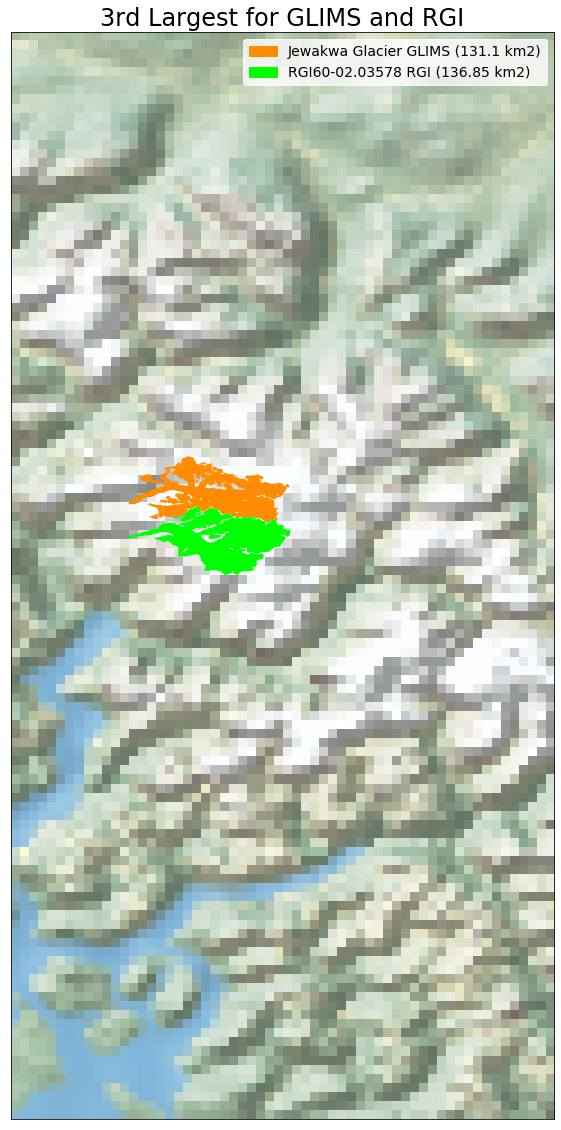

In [32]:
# Plot 3rd largest glacier for GLIMS and RGI. They are different.
legend_colors = ['darkorange', 'lime']
legend_labels = [glims_glaciers_df['glac_name'][2] + ' GLIMS (' + str(glims_glaciers_df['area'][2]) + ' km2)',
                 rgi_glaciers_df['RGIId'][2] + ' RGI (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
#minx, miny, maxx, maxy = region_outline.total_bounds
minx, miny, maxx, maxy = closeup
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='lime')
ax.set_title('3rd Largest for GLIMS and RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

In [22]:
minx

-134.0017344

In [23]:
miny

35.0

In [24]:
maxx

-104.0

In [25]:
maxy

74.0

In [26]:
region_outline.total_bounds

array([-134.0017344,   35.       , -104.       ,   74.       ])

In [30]:
closeup = [-125, 50, -124, 52]
closeup

[-125, 50, -124, 52]